## Экстраполяция временных рядов. 

### Задание 

Необходимо взять не менее 100 значений и разбить их на 2 выборки (80/20) и использовать первые 80 значений для обучения моделей:
- методом МНК (квадратичная гипотеза), 
<!-- - методом kNN,  -->
- методом SVM, 
- методом Lasso, 
- методом PLS. 

Использовать не менее 2-х параметров для прогнозирования целевого параметра. Добавить к параметрам из варианта, значения целевого параметра со сдвигом на один шаг в прошлое (отставание от прогнозируемого значения на один шаг). Построить графики получаемых с использованием построенных моделей функций и нанести значения из тренировочной и тестовой выборок.

Построить графики получаемых с использованием построенных моделей функций и нанести значения из тренировочной и тестовой выборок.
Подсчитать RMSE для каджого метода.



### Данные
* DataSet5_1 – «Динамика цен на основные социально значимые продовольственные товары в розничной сети Свердловской области» (данные сортированы по следующим столбцам:   
1) Дата мониторинга;   
2) кура охлажденная и мороженая. руб./кг;  
3) молоко цельное питьевое 2.5-3.2% жирности. руб./л.;  
4) мука пшеничная в/с. руб./кг;   
5) хлеб и булочные изделия из пшеничной муки 1 и 2 с.. руб./кг;  
6) яйцо куриное. руб./дес.;  
7) картофель. руб./кг.
* DataSet5_2 – Данные об аренде велосипедов
* DataSet1_3 – Стоимость и объем продаж акций компании Google 
* DataSet1_4 – статистика заболеваемости COVID-19 по странам

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

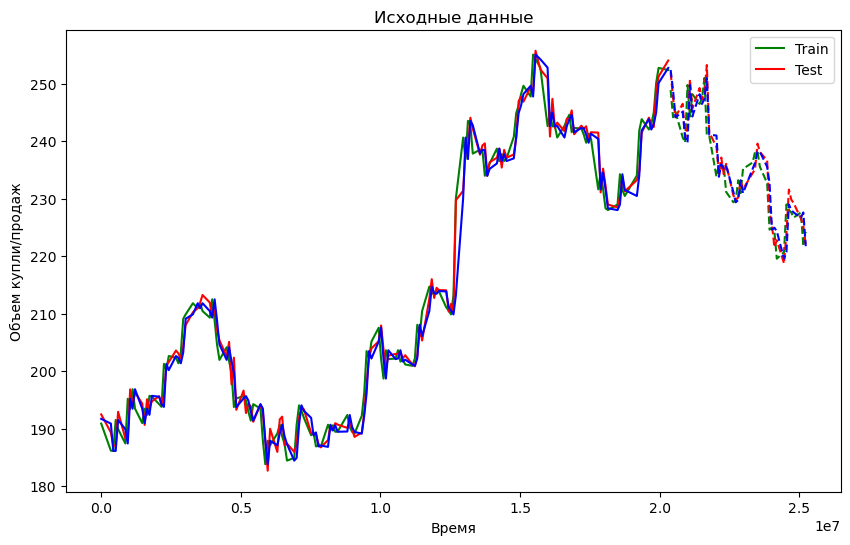

In [2]:
data1 = pd.read_csv('DataSet1_3.csv', sep = ',')
data2 = pd.read_csv('DataSet1_4.csv', sep = ',')

data3 = pd.read_csv('DataSet5_1.csv', sep = ',')
data4 = pd.read_csv('DataSet5_2.csv', sep = ';')

data1[["Date"]] = data1[["Date"]].apply(pd.to_datetime)
data1['Date'] =   (data1['Date']).astype(np.int64)/1000000000 #нс -> c

start_idx = 100
end_idx = 300

data = pd.DataFrame()
data['x'] = data1['Date'][start_idx:end_idx].to_numpy() - data1['Date'][start_idx] + 1
data['y'] = data1['Close'][start_idx:end_idx].to_numpy()
data['p1'] = data1['Open'][start_idx:end_idx].to_numpy()
data['p2'] = data1['Close'][start_idx-1:end_idx-1].to_numpy()

n = round(0.8*(end_idx - start_idx))

train = data[0:n]
test = data[n:]

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(train['x'], train['y'], color='green', linestyle = 'solid')
ax.plot(train['x'], train['p1'], color='red', linestyle = 'solid')
ax.plot(train['x'], train['p2'], color='blue', linestyle = 'solid')
ax.plot(test['x'], test['y'], color='green', linestyle = 'dashed')
ax.plot(test['x'], test['p1'], color='red', linestyle = 'dashed')
ax.plot(test['x'], test['p2'], color='blue', linestyle = 'dashed')

ax.set(title="Исходные данные", xlabel="Время", ylabel="Объем купли/продаж")

ax.legend(['Train', 'Test'])
plt.show()

In [3]:
data

,x,y,p1,p2
0,1.0,190.87,192.47,191.69
1,345601.0,186.16,189.33,190.87
2,432001.0,186.10,187.09,186.16
3,518401.0,191.50,186.96,186.10
4,604801.0,189.91,192.92,191.50
...,...,...,...,...
195,24710401.0,227.59,229.84,228.05
196,24796801.0,226.71,229.23,227.59
197,25056001.0,227.60,226.51,226.71
198,25142401.0,221.74,225.28,227.60


In [4]:
train

,x,y,p1,p2
0,1.0,190.87,192.47,191.69
1,345601.0,186.16,189.33,190.87
2,432001.0,186.10,187.09,186.16
3,518401.0,191.50,186.96,186.10
4,604801.0,189.91,192.92,191.50
...,...,...,...,...
155,19699201.0,242.99,242.97,242.03
156,19785601.0,244.97,242.46,242.99
157,19872001.0,250.11,248.85,244.97
158,19958401.0,252.75,251.25,250.11


In [5]:
train_x = train.drop(['y'], axis=1, inplace=False)
train_y = train['y']
test_x = test.drop(['y'], axis=1, inplace=False)
test_y = test['y']

In [6]:
train_x

,x,p1,p2
0,1.0,192.47,191.69
1,345601.0,189.33,190.87
2,432001.0,187.09,186.16
3,518401.0,186.96,186.10
4,604801.0,192.92,191.50
...,...,...,...
155,19699201.0,242.97,242.03
156,19785601.0,242.46,242.99
157,19872001.0,248.85,244.97
158,19958401.0,251.25,250.11


In [7]:
train_y

0      190.87
1      186.16
2      186.10
3      191.50
4      189.91
        ...  
155    242.99
156    244.97
157    250.11
158    252.75
159    252.39
Name: y, Length: 160, dtype: float64

### МНК

In [8]:
from scipy.optimize import curve_fit 

def mapping_func(x, a, b, c, b1, b2): 
    return a + b * x['x'] + c * x['x']**2 + b1 * x['p1'] + b2 * x['p2']

args, covar = curve_fit(mapping_func, train_x, train_y)

a, b, c, b1, b2 = args[0], args[1], args[2], args[3], args[4]

res_y_tr = a + b * train['x'] + c * train['x']**2 + b1 * train['p1'] + b2 * train['p2']
res_y_ts = a + b * test['x'] + c * test['x']**2 + b1 * test['p1'] + b2 * test['p2']

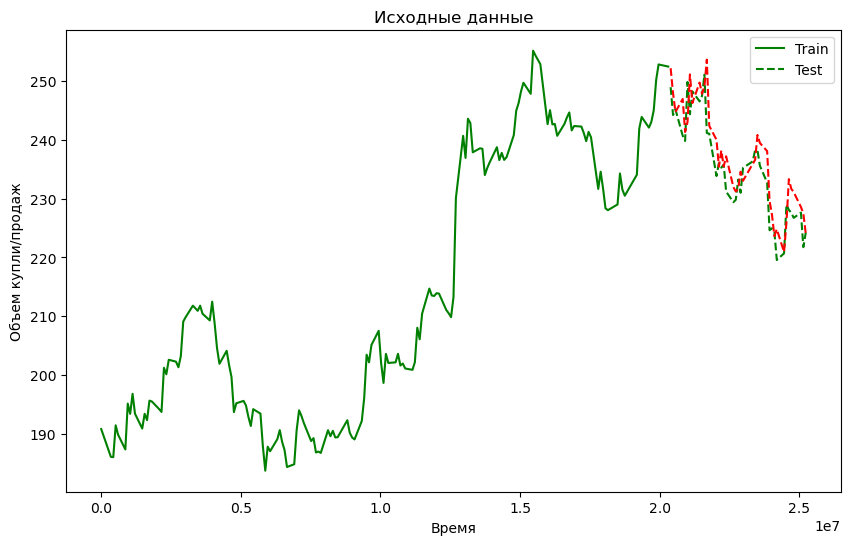

In [9]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(train['x'], train['y'], color='green', linestyle = 'solid')
ax.plot(test['x'], test['y'], color='green', linestyle = 'dashed')
ax.plot(test['x'], res_y_ts, color='red', linestyle = 'dashed')

ax.set(title="Исходные данные", xlabel="Время", ylabel="Объем купли/продаж")

ax.legend(['Train', 'Test'])
plt.show()

### SVM

In [10]:
from sklearn.svm import SVR

In [11]:
model = SVR(kernel = 'rbf')
model.fit(train_x, train_y)

SVR()

In [12]:
res_y_tr = model.predict(train_x)
res_y_ts = model.predict(test_x)

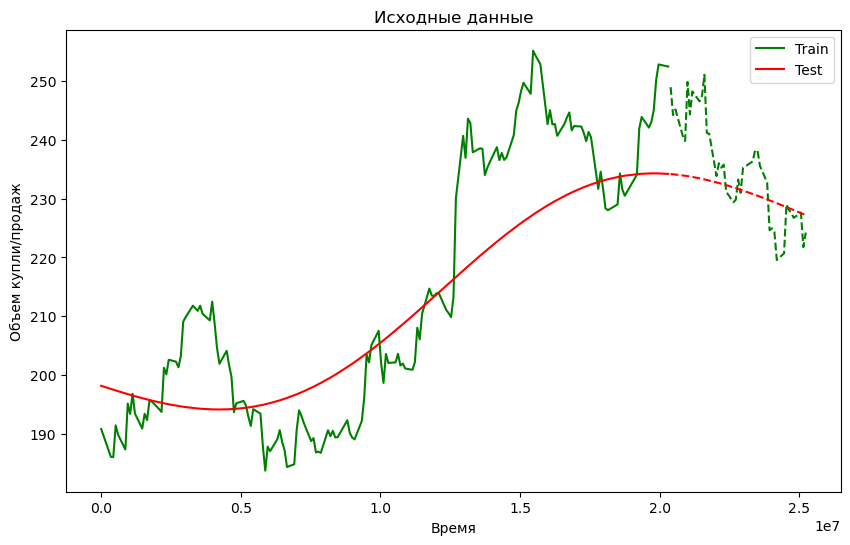

In [13]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(train['x'], train['y'], color='green', linestyle = 'solid')
ax.plot(train['x'], res_y_tr, color='red', linestyle = 'solid')
ax.plot(test['x'], test['y'], color='green', linestyle = 'dashed')
ax.plot(test['x'], res_y_ts, color='red', linestyle = 'dashed')

ax.set(title="Исходные данные", xlabel="Время", ylabel="Объем купли/продаж")

ax.legend(['Train', 'Test'])
plt.show()

### lasso

In [14]:
from sklearn.linear_model import Lasso

In [15]:
# https://www.kirenz.com/post/2019-08-12-python-lasso-regression-auto/
lasso_model = Lasso(alpha=1)
lasso_model.fit(train_x, train_y)
# Lasso(alpha=1)

c:\Users\picni\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.487e+02, tolerance: 7.747e+00
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=1)

In [16]:
lasso_res_y_tr = lasso_model.predict(train_x)
lasso_res_y_ts = lasso_model.predict(test_x)

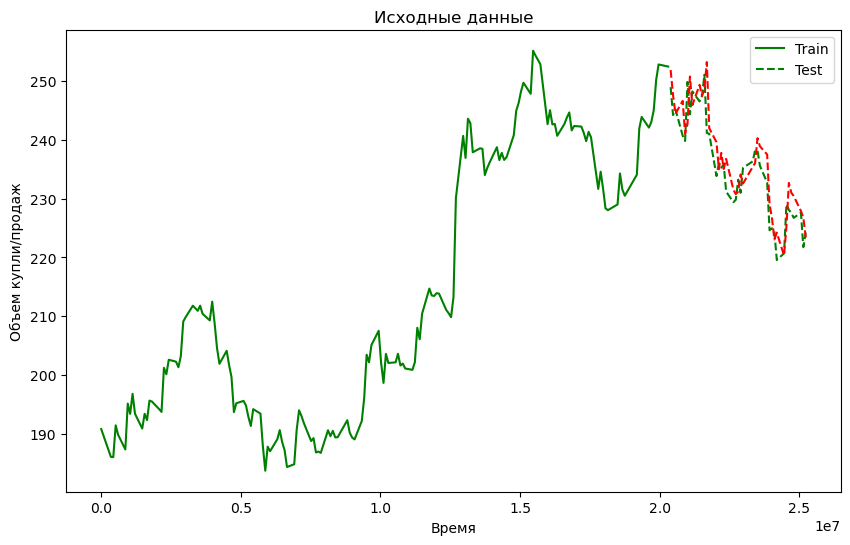

In [17]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(train['x'], train['y'], color='green', linestyle = 'solid')
# ax.plot(train['x'], lasso_res_y_tr, color='red', linestyle = 'solid')
ax.plot(test['x'], test['y'], color='green', linestyle = 'dashed')
ax.plot(test['x'], lasso_res_y_ts, color='red', linestyle = 'dashed')

ax.set(title="Исходные данные", xlabel="Время", ylabel="Объем купли/продаж")

ax.legend(['Train', 'Test'])
plt.show()

### PLS

In [18]:
from sklearn.cross_decomposition import PLSRegression
# from sklearn.model_selection import cross_val_predict

In [19]:
# https://nirpyresearch.com/partial-least-squares-regression-python/
pls = PLSRegression(n_components=3)
pls.fit(train_x, train_y)

PLSRegression(n_components=3)

In [20]:
pls_res_y_tr = pls.predict(train_x)
pls_res_y_ts = pls.predict(test_x)

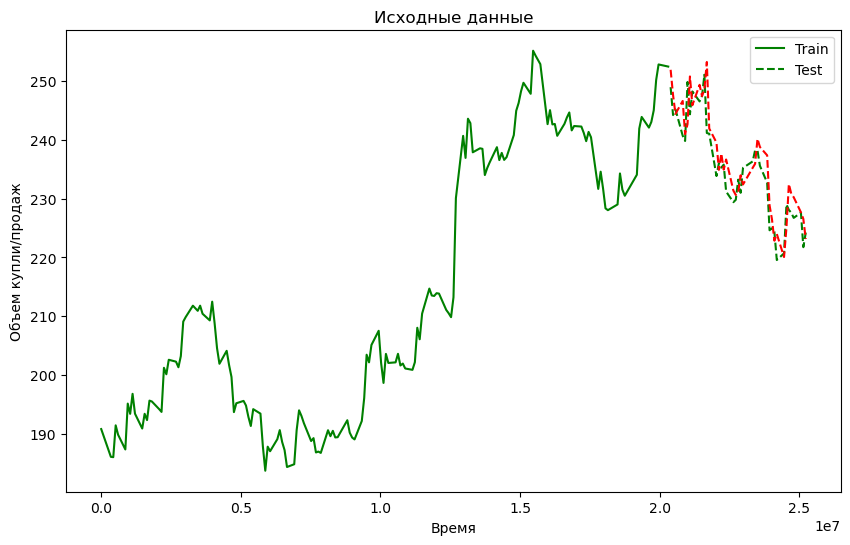

In [21]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(train['x'], train['y'], color='green', linestyle = 'solid')
# ax.plot(train['x'], pls_res_y_tr, color='red', linestyle = 'solid')
ax.plot(test['x'], test['y'], color='green', linestyle = 'dashed')
ax.plot(test['x'], pls_res_y_ts, color='red', linestyle = 'dashed')

ax.set(title="Исходные данные", xlabel="Время", ylabel="Объем купли/продаж")

ax.legend(['Train', 'Test'])
plt.show()